In [2]:
import tweepy
import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
from config import consumer_key, consumer_secret, access_token, access_token_secret
import matplotlib.pyplot as plt
from datetime import datetime
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
analyzer = SentimentIntensityAnalyzer() # Initialize the class 

ModuleNotFoundError: No module named 'config'

In [ ]:
# Twitter credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [3]:
news_organization_list = [('BBC', '@BBC'), ('CBS', '@CBS'), ('CNN', '@CNN'), ('Fox', '@FoxNews'), ('New York Times', '@nytimes')]

In [4]:
news_organizations_df = pd.DataFrame(news_organization_list, columns = ['name', 'handle'])

In [5]:
news_organizations_df

,name,handle
0,BBC,@BBC
1,CBS,@CBS
2,CNN,@CNN
3,Fox,@FoxNews
4,New York Times,@nytimes


In [37]:
nbr_tweets = 100

In [7]:
def get_df_for_user_tweets(username):
    try:
        target_tweets = []
        for status in tweepy.Cursor(api.user_timeline, id=username).items(nbr_tweets):
            target_tweets.append(status)
        temp_df = pd.DataFrame([ (x.user._json['screen_name'], x.text, x.created_at, analyzer.polarity_scores(x.text))
                                for x in target_tweets])
        temp_df.columns = ['user', 'tweet_text', 'created', 'sentiment']
        return temp_df
    except Exception as e:
        print(str(e), "Please debug this!")

In [8]:
# Create a 'tweets' DataFrame for each row of the 'news organizations' DataFrame
news_organizations_df['tweets'] = news_organizations_df.handle.map(get_df_for_user_tweets)

In [9]:
def df_to_list(df):
    return list(df.T.to_dict().values())

def normalize_df(df):
    return json_normalize(df_to_list(df))

In [10]:
# Flatten out the 'sentiment' dictionary column of the 'tweets' DataFrames
news_organizations_df['tweets'] = news_organizations_df['tweets'].map(normalize_df)

In [11]:
news_organizations_df['tweets'][0].head()

,created,sentiment.compound,sentiment.neg,sentiment.neu,sentiment.pos,tweet_text,user
0,2018-06-24 19:03:02,0.0000,0.000,1.000,0.000,"Follow the inner workings of @nytimes, one of ...",BBC
1,2018-06-24 18:32:03,-0.5574,0.153,0.847,0.000,🚗 🇸🇦 Women in Saudi Arabia are hitting the roa...,BBC
2,2018-06-24 18:10:27,0.5994,0.000,0.755,0.245,"RT @BBCWthrWatchers: Beautiful ""night shining""...",BBC
3,2018-06-24 18:04:04,-0.5267,0.195,0.805,0.000,This. Will. Hurt.\n\n@IdrisElba returns as the...,BBC
4,2018-06-24 17:08:05,0.6705,0.078,0.658,0.263,43% of female festival goers under 40 say they...,BBC


In [12]:
# Check to make sure tweepy returned all the tweets in reverse chronological order
# To confirm that the sanity check below does actually work, experimentally intervene using the commented line below:
#news_organizations_df['tweets'][1]['created'][1] = datetime.now()

if any((tf['created'][i] - tf['created'][i-1]).total_seconds() > 0 
    for tf in news_organizations_df['tweets']
         for i in range(1, len(tf) - 1)):
       print ("Unexpected timestamp sequence")

In [13]:
def mean(l):
    return sum(l) / len(l)

In [14]:
news_organizations_df['sentiments'] = [x['sentiment.compound'] for x in news_organizations_df.tweets]
news_organizations_df['mean_sentiment'] = [mean(x) for x in news_organizations_df['sentiments']]

In [39]:
news_organizations_df.head()

,name,handle,tweets,sentiments,mean_sentiment
0,BBC,@BBC,"[{'created': 2018-06-24 19:03:02, 'sentiment.c...",0 0.0000 1 -0.5574 2 0.5994 3 -0...,0.170314
1,CBS,@CBS,"[{'created': 2018-06-22 21:19:06, 'sentiment.c...",0 0.1867 1 0.4199 2 0.4926 3 0...,0.347950
2,CNN,@CNN,"[{'created': 2018-06-24 23:15:53, 'sentiment.c...",0 -0.6705 1 0.0000 2 -0.1531 3 0...,-0.036640
3,Fox,@FoxNews,"[{'created': 2018-06-24 23:15:43, 'sentiment.c...",0 0.0000 1 0.1280 2 0.1531 3 -0...,-0.022524
4,New York Times,@nytimes,"[{'created': 2018-06-24 23:06:36, 'sentiment.c...",0 0.6369 1 0.0000 2 -0.5574 3 -0...,0.046975


In [40]:
def plot_sentiments(name, sentiments, nbr_tweets):
    now = datetime.now()
    #It's a bit tricky to reverse the x axis
    plt.stem(list(range(1-nbr_tweets,1)), list(reversed(sentiments[0:nbr_tweets])))
    plt.title(f"Sentiment Analysis of {name} Tweets ({now.month}/{now.day}/{now.year})")
    plt.xlabel('Tweets Ago')
    plt.ylabel('Tweet Polarity')
    plt.savefig(str(name))
    plt.show()

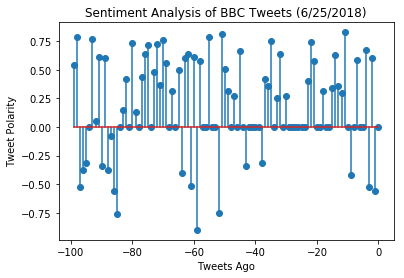

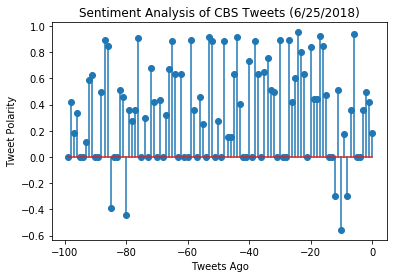

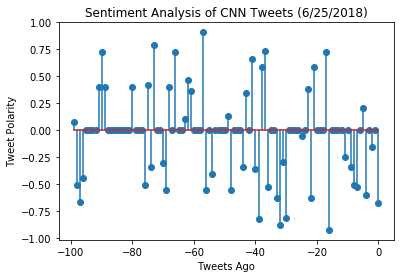

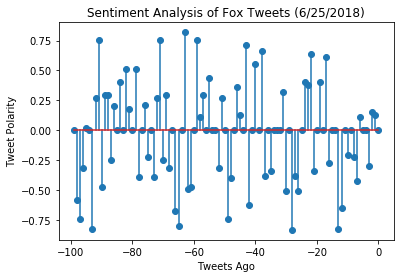

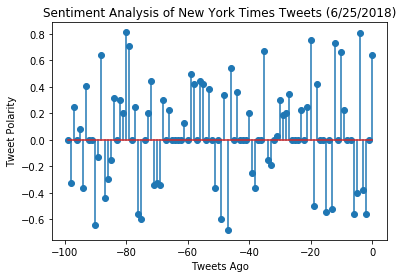

0    None
1    None
2    None
3    None
4    None
dtype: object

In [44]:
news_organizations_df.apply(lambda x: plot_sentiments(x['name'], x['sentiments'], nbr_tweets), axis=1)

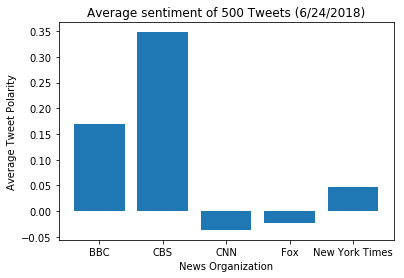

In [34]:
now = datetime.now()
plt.bar(news_organizations_df['name'], news_organizations_df['mean_sentiment']) 
plt.title(f"Average sentiment of {nbr_tweets} Tweets ({now.month}/{now.day}/{now.year})")
plt.xlabel('News Organization')
plt.ylabel('Average Tweet Polarity')
plt.savefig('Average_sentiments')
plt.show()

In [19]:
# Convert each 'tweets' DataFrame to a list of dicts
news_organizations_df['tweets'] = news_organizations_df['tweets'].map(df_to_list)

In [20]:
news_organizations_df

,name,handle,tweets,sentiments,mean_sentiment
0,BBC,@BBC,"[{'created': 2018-06-24 19:03:02, 'sentiment.c...",0 0.0000 1 -0.5574 2 0.5994 3 -0...,0.170314
1,CBS,@CBS,"[{'created': 2018-06-22 21:19:06, 'sentiment.c...",0 0.1867 1 0.4199 2 0.4926 3 0...,0.347950
2,CNN,@CNN,"[{'created': 2018-06-24 23:15:53, 'sentiment.c...",0 -0.6705 1 0.0000 2 -0.1531 3 0...,-0.036640
3,Fox,@FoxNews,"[{'created': 2018-06-24 23:15:43, 'sentiment.c...",0 0.0000 1 0.1280 2 0.1531 3 -0...,-0.022524
4,New York Times,@nytimes,"[{'created': 2018-06-24 23:06:36, 'sentiment.c...",0 0.6369 1 0.0000 2 -0.5574 3 -0...,0.046975


In [21]:
tweets_df = json_normalize(df_to_list(news_organizations_df), 'tweets')

In [22]:
tweets_df.head()

,created,sentiment.compound,sentiment.neg,sentiment.neu,sentiment.pos,tweet_text,user
0,2018-06-24 19:03:02,0.0000,0.000,1.000,0.000,"Follow the inner workings of @nytimes, one of ...",BBC
1,2018-06-24 18:32:03,-0.5574,0.153,0.847,0.000,🚗 🇸🇦 Women in Saudi Arabia are hitting the roa...,BBC
2,2018-06-24 18:10:27,0.5994,0.000,0.755,0.245,"RT @BBCWthrWatchers: Beautiful ""night shining""...",BBC
3,2018-06-24 18:04:04,-0.5267,0.195,0.805,0.000,This. Will. Hurt.\n\n@IdrisElba returns as the...,BBC
4,2018-06-24 17:08:05,0.6705,0.078,0.658,0.263,43% of female festival goers under 40 say they...,BBC


In [23]:
tweets_df.to_csv('Twitter_Sentiments.csv', index = False)